# EVALUATION NOTEBOOK

### Effect of Prefilters
The dataset was transcribed with two different prefilters.

In [ ]:
import h5py
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

def computeStatistics(data):
    median = np.median(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    return median,iqr

def getFscoreResults(filepath,alphabet="majmin",printMetadata=False):
    results = {"combined":[]}

    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in dataloader.OUTLIERS:
                    f_scores.append(subgrp.attrs.get(f"{alphabet}_f"))
            results[dset] = f_scores
            results["combined"] += f_scores
    return results

def plotResults(data,xlabels,colors,yticks=np.arange(-20,25,5),ylim=(-20,10),figsize=(5.5, 2.5)):
    """creates colored violinplots for data"""
    fig, ax1 = plt.subplots(figsize=figsize)
    parts = ax1.violinplot(data,showmeans=False, showmedians=True,
            showextrema=False)
    bplot = ax1.boxplot(data,
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
    parts["cmedians"].set_color("red")
    for x,color in zip(parts["bodies"],colors):
            x.set_color(color)

    ax1.set_yticks(yticks)
    ax1.set_ylim(ylim)
    ax1.set_ylabel("Delta F-score in %")
    ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
    ax1.set_xlim(0.5, len(xlabels) + 0.5);
    ax1.grid("on")
    fig.tight_layout(pad=0.1)
    return fig,ax1

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

rp_majmin = getFscoreResults("../results/recurrence_plot.hdf5","majmin",False)
rp_sevenths = getFscoreResults("../results/recurrence_plot.hdf5","sevenths")
median_majmin = getFscoreResults("../results/median_none.hdf5","majmin", True)
median_sevenths = getFscoreResults("../results/median_none.hdf5","sevenths")
print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "prefilter & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
printRow(rp_majmin,"RP","majmin")
printRow(median_majmin,"Median","majmin")
print("\\midrule")
printRow(rp_sevenths,"RP","sevenths")
printRow(median_sevenths,"Median","sevenths")
# plot paired difference
delta_f_majmin = []
delta_f_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    delta_f_majmin.append([100*(x-y) for x,y in zip(rp_majmin[dset],median_majmin[dset])])
    delta_f_sevenths.append([100*(x-y) for x,y in zip(rp_sevenths[dset],median_sevenths[dset])])
colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
fig,ax = plotResults(delta_f_majmin,xlabels,colors,np.arange(-15,20,5),ylim=(-20,20))
fig.savefig("../latex/figures/prefilter_delta_f_majmin.png")
fig,ax = plotResults(delta_f_sevenths,xlabels,colors,np.arange(-15,20,5),ylim=(-20,20))
fig.savefig("../latex/figures/prefilter_delta_f_sevenths.png")

# wilcoxon test
print("-----Wilcoxon test for paired samples MAJMIN-------")
print("dataset & N & z & p & r \\\\")
print("\\toprule")
for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
    res = scipy.stats.wilcoxon(delta_f_majmin[i],method='approx')
    N = len(delta_f_majmin[i])
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

print("-----Wilcoxon test for paired samples SEVENTHS-------")
print("dataset & N & z & p & r \\\\")
print("\\toprule")
for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
    res = scipy.stats.wilcoxon(delta_f_sevenths[i],method='approx')
    N = len(delta_f_sevenths[i])
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")


### Study on Source Separation
Vocals, drums were removed seperately with a hybrid transformer source separation network (demucs) to enhance the chroma.</br>
After seperating the drums, the vocals were again removed from the remaining signal.



In [53]:
def printHeader():
    print(f"----------Table of results------------")
    header = "separation & scheme &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        if dset == "rwc_pop":
            header += "rwc\_pop & "
        else:
            header += dset +" &"
    header = header[:-1] + "\\\\"
    print(header)

def printRowFscore(data,method="none",alphabet="majmin"):
    text = f"{method} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def printRowTtest(data,pair="none",alphabet="majmin"):
    res = scipy.stats.wilcoxon(data,method='approx')
    N = len(data)
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {pair} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {pair} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

printHeader()
data = {}
for alphabet in ["majmin","sevenths"]:
    for separation in ["none","vocals","drums","both"]:
        key = separation+"-"+alphabet
        data[key] = getFscoreResults(f"../results/source_separation_{separation}",alphabet=alphabet)
        printRowFscore(data[key],method=separation,alphabet=alphabet)

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
row = "Comparison Pair"
for sep in ["vocals","drums","both"]:
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        key = separation+"-"+"majmin"
        delta = [100*(x-y) for x,y in zip(data["none"+"-"+"majmin"][dset],data[key][dset])]
        printRowTtest(delta,f"none, {sep}")

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
row = "Comparison Pair"
for sep in ["vocals","drums","both"]:
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        key = separation+"-"+"sevenths"
        delta = [100*(x-y) for x,y in zip(data["none"+"-"+"sevenths"][dset],data[key][dset])]
        printRowTtest(delta,f"none, {sep}")


----------Table of results------------
separation & scheme &beatles &rwc\_pop & rw &queen &combined \\
none & majmin &0.75$\pm$0.15 &0.76$\pm$0.16 &0.76$\pm$0.14 &0.70$\pm$0.17 &0.75$\pm$0.15 \\
vocals & majmin &0.76$\pm$0.13 &0.77$\pm$0.15 &0.78$\pm$0.14 &0.69$\pm$0.17 &0.77$\pm$0.13 \\
drums & majmin &0.75$\pm$0.13 &0.78$\pm$0.14 &0.79$\pm$0.15 &0.73$\pm$0.17 &0.76$\pm$0.14 \\
both & majmin &0.76$\pm$0.12 &0.77$\pm$0.13 &0.79$\pm$0.13 &0.76$\pm$0.19 &0.77$\pm$0.13 \\
none & sevenths &0.68$\pm$0.19 &0.67$\pm$0.19 &0.70$\pm$0.15 &0.62$\pm$0.18 &0.68$\pm$0.18 \\
vocals & sevenths &0.68$\pm$0.18 &0.67$\pm$0.21 &0.73$\pm$0.14 &0.64$\pm$0.16 &0.69$\pm$0.19 \\
drums & sevenths &0.67$\pm$0.17 &0.67$\pm$0.21 &0.72$\pm$0.13 &0.65$\pm$0.19 &0.68$\pm$0.18 \\
both & sevenths &0.68$\pm$0.16 &0.68$\pm$0.21 &0.74$\pm$0.14 &0.64$\pm$0.20 &0.69$\pm$0.17 \\
--------comparison pairs for wilcoxon test----
beatles & none, vocals & 175 & -2.5 & 0.014 & 0.2\\
rwc_pop & none, vocals & 100 & -4.5 & $<$.001 & 

### NSGT-CQT  --- Tuning issues

In [ ]:
import numpy as np
import utils
import matplotlib.pyplot as plt
import dataloader
import librosa.display
import librosa
import nsgt

dset = "rwc_pop"
track_id = "RM-P002" 
time_interval = (5,15)
## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 
class interpolate:
    def __init__(self,cqt,Ls):
        from scipy.interpolate import interp1d
        self.intp = [interp1d(np.linspace(0, Ls, len(r)), r) for r in cqt]
    def __call__(self,x):
        try:
            len(x)
        except:
            return np.array([i(x) for i in self.intp])
        else:
            return np.array([[i(xi) for i in self.intp] for xi in x]) 
        
dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id]
gt = utils.loadChordAnnotations(annotationpath)
sig = utils.loadAudiofile(audiopath,offset=time_interval[0],duration=time_interval[1]-time_interval[0])
estimated_tuning = librosa.estimate_tuning(y=sig,sr=22050)
f0 = librosa.tuning_to_A4(estimated_tuning)
print(f"f0={f0:0.1f} Hz")
midi2hz = lambda m,f0 : f0*(2.0**((m-69.0)/12.0))
fs = 22050
octaves = 6

fmin = midi2hz(24,f0) # C2
fmax = midi2hz(24 + 12*octaves,f0) # C6
bpo = 12
cq_nsgt = nsgt.CQ_NSGT(fmin,fmax, bpo,fs, len(sig))
# forward transform 
coeffs = cq_nsgt.forward(sig)

# interpolate CQT to get a grid
x = np.arange(0, len(sig), 64)
cqt = interpolate(map(np.abs, coeffs[2:]), len(sig))(x).T#

from scipy.fftpack import dct,idct
pitchgram_energy = cqt**2
pitchgram_energy = np.log(100 * pitchgram_energy + 1);  
vLogDCT = dct(pitchgram_energy, norm='ortho', axis=0);  
vLogDCT[:33,:] = 0 
vLogDCT[33,:] = 0.5 * vLogDCT[33,:]
pitchgram_energy = idct(vLogDCT, norm='ortho', axis=0)

chroma = np.zeros((12,pitchgram_energy.shape[1]),dtype=float)
for i in range(pitchgram_energy.shape[0]):
    index = i % 12
    chroma[(i+1) % 12,:] += pitchgram_energy[i,:]
chroma = chroma / np.sum(np.abs(chroma) + np.finfo(float).eps, axis=0)
fig,ax = plt.subplots(3,1,height_ratios=(10,1,5),figsize=(9,5))
t_cqt = time_interval[0] + x / fs
cqt_db = 20 * np.log10(cqt)
pmax = np.percentile(cqt_db, 99.99)
img = librosa.display.specshow(cqt_db,
                         ax=ax[0],x_coords=t_cqt,y_axis="cqt_hz",
                         fmin=fmin,fmax=fmax,x_axis="s",
                         cmap="viridis",vmax=pmax,vmin=pmax-80)
utils.plotChordAnnotations(ax[1],gt[0],gt[1],time_interval)
utils.plotChromagram(ax[2],t_cqt,chroma);

### CQT and pitchgram analysis

In [ ]:
import librosa
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
import dataloader
import librosa.display
import IPython.display as ipd
plt.ion()
dset = "rwc_pop"
track_id = "RM-P003" 

## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id] 
sig = utils.loadAudiofile(audiopath,duration=20)
gt = utils.loadChordAnnotations(annotationpath)

####### tuned CQT ############
midi_start = 36
octaves = 6
cqt_params = {"sr":22050,"bins_per_octave":36,"hop_length":1024,"fmin":librosa.midi_to_hz(midi_start)}

estimated_tuning = librosa.estimate_tuning(y=sig,sr=22050,bins_per_octave=36)
C = np.abs(librosa.vqt(sig,filter_scale=1,tuning=estimated_tuning,gamma=0,n_bins=octaves*36, **cqt_params))
C_db = 20 * np.log10(C+ np.finfo(float).eps)
pmax = np.percentile(C_db, 99.99)

time = (5,15)
fig,(ax0,ax1) = plt.subplots(2,1,height_ratios=(1,10),figsize=(6,4))
## librosa
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval=time)
img = librosa.display.specshow(C_db,
                         ax=ax1,y_axis="cqt_hz",x_axis="s",
                         vmax=pmax, vmin=pmax - 80,
                         cmap="viridis",**cqt_params)
ax1.set_xlim(time)
fig.tight_layout()

In [ ]:
## apply gaussian window function to deemphasize low frequent hum and overtones 
## centered around C4 +/- 15 note 
window=True
pitchgram_cqt = np.zeros((12*octaves,C.shape[1]),dtype=float)
pitchgram_cqt_windowed = np.zeros((12*octaves,C.shape[1]),dtype=float)
# pitchgram window function
for note in range(midi_start, midi_start+12*octaves):
    # weight and pick every third amplitude value
    pitchgram_cqt[note - midi_start,:] =  C[(note-midi_start)*3, :]
    pitchgram_cqt_windowed[note - midi_start,:] = np.exp(-(note-60)**2 / (2*15**2)) * C[(note-midi_start)*3,:] 
pitchgram_energy = pitchgram_cqt ** 2

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(6,4))
pitchgram_params = cqt_params
pitchgram_params["bins_per_octave"] = 12
librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt,ref=np.max),
                         ax=ax0,y_axis="cqt_hz",x_axis="s",cmap="viridis",**pitchgram_params)
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt_windowed,ref=np.max),
                         ax=ax1,x_axis="s",cmap="viridis",**pitchgram_params)
ax0.set_xlim(time)
ax1.set_xlim(time)
fig.colorbar(img);

In [ ]:
### Logarithmic Compression and Liftering 
eta = 100
nCRP = 33
if True:
    pitchgram_log = np.log(eta * pitchgram_energy + 1)
else:
    pitchgram_log = pitchgram_cqt
vLogDCT = dct(pitchgram_log, norm='ortho', axis=0);  
vLogDCT[:nCRP,:] = 0 
vLogDCT[nCRP,:] = 0.5 * vLogDCT[nCRP,:]
pitchgram_lift = idct(vLogDCT, norm='ortho', axis=0)

# pitch folding
crp = pitchgram_lift.reshape(octaves,12,-1) 
crp = np.sum(crp, axis=0)
crp = np.clip(crp,0,None) # clip negative values
crp = crp /np.sum(np.abs(crp) + np.finfo(float).tiny, axis=0) # apply manhattan norm

t_chroma = utils.timeVector(crp.shape[1],hop_length=cqt_params["hop_length"])

fig,((ax0,ax00),(ax1,ax11),(ax2,ax22),(ax3,ax33)) = plt.subplots(4,2,figsize=(7,7),width_ratios=(10,.1),height_ratios=(2,2,0.3,1))
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_log,ref=np.max),
                         ax=ax0,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params)
fig.colorbar(img,cax=ax00)
ax0.set_title("log compressed pitchgram (dB)")
img = librosa.display.specshow(pitchgram_lift,
                         ax=ax1,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params,vmin=-3,vmax=3)
fig.colorbar(img,cax=ax11)
ax1.set_title("liftered pitchgram")
for ax in [ax0,ax1]:
    ax.set_xlabel("")
ax2.set_title("CRP feature with annotations")
utils.plotChordAnnotations(ax2,gt[0],gt[1],time_interval=time)
ax22.set_axis_off()
ax2.set_xlabel("")
ax2.set_xticklabels([])
img = utils.plotChromagram(ax3,t_chroma,crp)
fig.colorbar(img,cax=ax33);
fig.tight_layout()

### Transsprition Results

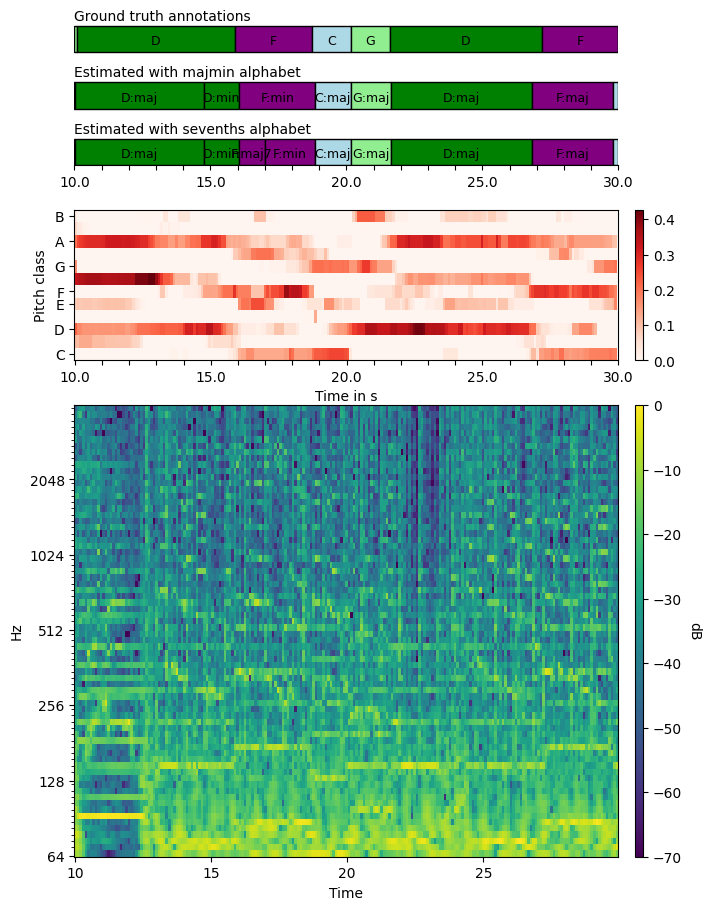

Corrupt File: No Metadata indicating used datasets available..
Corrupt File: No Metadata indicating used datasets available..


In [1]:
import matplotlib.pyplot as plt
from visualization import visualizationApp
%matplotlib inline
visualizationApp("../results");
plt.ioff(); # interactive mode off

### Comparison of results between rp and median filtering and the deep chroma processor

In [ ]:
from visualization import load_results
from dataloader import OUTLIERS
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import utils

results_median,datasets = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/median_none.hdf5")
results_rp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/rp_none.hdf5")
results_dcp,_ = load_results("/home/max/ET-TI/Masterarbeit/chord-recognition/results/dcp_none.hdf5")

results_median = [x for x in results_median if x.name not in OUTLIERS]
results_rp = [x for x in results_rp if x.name not in OUTLIERS]
               
majmin_dcp = [100*x.majmin_f for x in results_dcp]
sevenths_dcp = [100*x.sevenths_f for x in results_dcp]

comparison_median_dcp = [(x,y) for x,y in zip(results_median,results_dcp) if x.majmin_f > y.majmin_f ]
# for data in comparison_median_dcp:
#     print(f"{data[0].name} -{data[0].track_id} - MEDIAN: {data[0].majmin_f} , DCP: {data[1].majmin_f}")

majmin_f_median = [100*x.majmin_f for x in results_median]
sevenths_f_median = [100*x.sevenths_f for x in results_median]
majmin_f_rp = [100*x.majmin_f for x in results_rp]
sevenths_f_rp = [100*x.sevenths_f for x in results_rp]

fig, ax = plt.subplots(figsize=(3, 2.8))
utils.create_violinplot(ax,[majmin_f_median,majmin_dcp],["Median","DCP"],"DodgerBlue")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_majmin_result.png")

fig, ax = plt.subplots(figsize=(3, 2.8)) 
utils.create_violinplot(ax,[sevenths_f_median,sevenths_dcp],["Median","DCP"],"DodgerBlue")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_sevenths_result.png")

majmin_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS]
majmin_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS]
beatles_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "beatles"]
beatles_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "beatles"]
rwc_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rwc_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rw_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rw"]
rw_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rw"]
queen_f = [100*x.majmin_f for x in results_median if x.name not in OUTLIERS and x.dataset == "queen"]
queen_f_rp = [100*x.majmin_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "queen"]

majmin_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS]
majmin_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS]
beatles_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "beatles"]
beatles_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "beatles"]
rwc_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rwc_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rwc_pop"]
rw_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "rw"]
rw_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "rw"]
queen_f_sev = [100*x.sevenths_f for x in results_median if x.name not in OUTLIERS and x.dataset == "queen"]
queen_f_rp_sev = [100*x.sevenths_f for x in results_rp if x.name not in OUTLIERS and x.dataset == "queen"]

delta_f = [x-y for x,y in zip(majmin_f_rp,majmin_f)]
beatles_delta = [x-y for x,y in zip(beatles_f_rp,beatles_f)]
rwc_delta = [x-y for x,y in zip(rwc_f_rp,rwc_f)]
rw_delta = [x-y for x,y in zip(rw_f_rp,rw_f)]
queen_delta = [x-y for x,y in zip(queen_f_rp,queen_f)]
data = [delta_f,beatles_delta,rwc_delta,rw_delta,queen_delta]
xlabels = ["Combined","Beatles", "RWC_pop","RW","Queen"]

fig,ax =fig, ax = plt.subplots(figsize=(5.5, 2.5))
violin_parts = ax.violinplot(data,showmeans=False, showmedians=True,
        showextrema=False)
violin_parts["cmedians"].set_color("red")
for x,color in zip(violin_parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
bplot_parts = ax.boxplot(data,
            showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
            flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
            widths=0.1)
ax.set_yticks(np.arange(-10,15,5))
ax.set_ylim(-15,15)
ax.set_ylabel("Delta F-score in %")
ax.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax.set_xlim(0.5, len(xlabels) + 0.5);
ax.grid("on")
fig.tight_layout(pad=0.1)
fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_dataset.png")


delta_f = [x-y for x,y in zip(majmin_f_rp_sev,majmin_f_sev)]
beatles_delta = [x-y for x,y in zip(beatles_f_rp_sev,beatles_f_sev)]
rwc_delta = [x-y for x,y in zip(rwc_f_rp_sev,rwc_f_sev)]
rw_delta = [x-y for x,y in zip(rw_f_rp_sev,rw_f_sev)]
queen_delta = [x-y for x,y in zip(queen_f_rp_sev,queen_f_sev)]
data = [delta_f,beatles_delta,rwc_delta,rw_delta,queen_delta]
xlabels = ["Combined","Beatles", "RWC_pop","RW","Queen"]

fig,ax =fig, ax = plt.subplots(figsize=(5.5, 2.5))
violin_parts = ax.violinplot(data,showmeans=False, showmedians=True,
        showextrema=False)
violin_parts["cmedians"].set_color("red")
for x,color in zip(violin_parts["bodies"],['r','g','b','purple']):
    x.set_color(color)
bplot_parts = ax.boxplot(data,
            showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
            flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
            widths=0.1)
ax.set_yticks(np.arange(-10,15,5))
ax.set_ylim(-15,15)
ax.set_ylabel("Delta F-score in %")
ax.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax.set_xlim(0.5, len(xlabels) + 0.5);
ax.grid("on")
fig.tight_layout(pad=0.1)
# fig.savefig("/home/max/ET-TI/Masterarbeit/latex/figures/median_rp_dataset_sevenths.png")


#### Study on correlation vs inner product

-----majmin-------------
 Title   |  Inner  | Corr
08_-_Love_Me_Do 0.61 0.81
05_-_Little_Child 0.8 0.69
11_-_I_Wanna_Be_Your_Man 0.84 0.58
02_-_I_Should_Have_Known_Better 0.64 0.8
07_-_Kansas_City-_Hey,_Hey,_Hey,_Hey 0.88 0.76
07_-_Ticket_To_Ride 0.7 0.41
01_-_Taxman 0.53 0.41
04_-_Love_You_To 0.58 0.47
11_-_Doctor_Robert 0.85 0.63
01_-_Sgt 0.6 0.46
05_-_Fixing_A_Hole 0.57 0.32
02_-_The_Fool_On_The_Hill 0.62 0.74
CD1_-_02_-_Dear_Prudence 0.33 0.53
CD2_-_01_-_Birthday 0.72 0.57
CD2_-_03_-_Mother_Nature's_Son 0.52 0.4
CD2_-_06_-_Helter_Skelter 0.62 0.45
CD2_-_10_-_Savoy_Truffle 0.76 0.61
CD2_-_13_-_Good_Night 0.62 0.76
16_-_The_End 0.55 0.45
07_-_Maggie_Mae 0.89 0.78
08_-_I've_Got_A_Feeling 0.32 0.57
12_-_Get_Back 0.75 0.5
Koino Ver.2.4 0.83 0.71
Game of Love 0.7 0.8
Tokimeki no syunkan 0.86 0.75
SHAKE 0.8 0.61
tell me 0.45 0.55
Be with me Now 0.66 0.86
Sagashimono 0.45 0.76
Life Is What You Make It To Be 0.82 0.6
Weekend 0.6 0.73
31 BLUES 0.65 0.4
04 Fat Bottomed Girls 0.8 0.69
14 Hamme

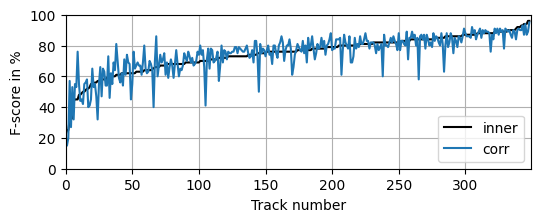

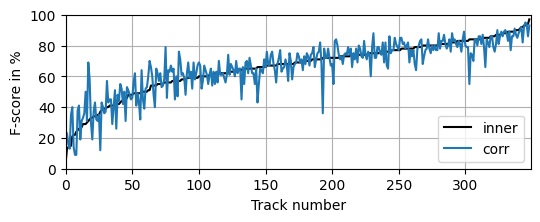

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py
import dataloader

def plotResults(data,xlabels,colors,yticks=np.arange(-20,25,5),ylim=(-20,10),figsize=(5.5, 2.5)):
    """creates colored violinplots for data"""
    fig, ax1 = plt.subplots(figsize=figsize)
    parts = ax1.violinplot(data,showmeans=False, showmedians=True,
            showextrema=False)
    bplot = ax1.boxplot(data,
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
    parts["cmedians"].set_color("red")
    for x,color in zip(parts["bodies"],colors):
            x.set_color(color)

    ax1.set_yticks(yticks)
    ax1.set_ylim(ylim)
    ax1.set_ylabel("Delta F-score in %")
    ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
    ax1.set_xlim(0.5, len(xlabels) + 0.5);
    ax1.grid("on")
    fig.tight_layout(pad=0.1)
    return fig,ax1

def computeStatistics(data):
    median = np.median(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    return median,iqr

def getFscoreResults(filepath,alphabet="majmin",printMetadata=False):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in dataloader.OUTLIERS:
                    # check if track_id's are matching 
                    track_list.append(subgrp.attrs.get("name"))
                    # f_scores.append((subgrp.attrs.get(f"{alphabet}_f"),subgrp.attrs.get("name")))
                    f_scores.append(subgrp.attrs.get(f"{alphabet}_f"))
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]

for alphabet in ["majmin","sevenths"]:
    inner,track_list = getFscoreResults("../results/median_drums.hdf5",alphabet)
    corr,track_list = getFscoreResults("../results/correlation_median_drums.hdf5",alphabet)
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(inner[dset],corr[dset])])
    
    index_outliers = np.where(np.abs(deltas[-1]) > 10)[0]
    print(f"-----{alphabet}-------------")
    print(" Title   |  Inner  | Corr")
    for index in np.where(np.abs(deltas[-1]) > 10)[0]:
        print(track_list[index],inner["combined"][index],corr["combined"][index])
    # print sorted data
    index = np.argsort(inner["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(100*np.array(inner["combined"])[index],'k')
    ax.plot(100*np.array(corr["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["inner","corr"])
    fig.savefig(f"../latex/figures/corr_sorted_{alphabet}.png")
    #fig,ax = plotResults(delta,xlabels,colors,np.arange(-15,20,5),ylim=(-20,20))

